In [1]:
from perception import hashers
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from collections import defaultdict
from src.phishIRISData import PhishIRISDataset
from src.config import config

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

hasher = hashers.PHashF()

In [2]:
train_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="train", preprocess=False
)

In [3]:
kmeans = KMeans(init="k-means++", n_init="auto")
clusters = kmeans.fit(list(train_dataset.img_to_hash.values()))
data_transformed = kmeans.transform(list(train_dataset.img_to_hash.values()))

In [4]:
cluster_to_hash = defaultdict(list)
cluster_to_company = defaultdict(list)
for idx, (img_name, img_hash) in enumerate(train_dataset.img_to_hash.items()):
    hsh = hasher.vector_to_string(img_hash)
    cluster_to_hash[kmeans.labels_[idx]].append(hsh)
    cluster_to_company[kmeans.labels_[idx]].append(train_dataset.hash_to_company[hsh])

for cluster_id in cluster_to_company.keys():
    companies, counts = np.unique(cluster_to_company[cluster_id], return_counts=True)
    # get max element from counts and its company
    cluster_to_company[cluster_id] = companies[np.argmax(counts)]

In [5]:
cluster_to_company

defaultdict(list,
            {6: 'facebook',
             7: 'other',
             3: 'other',
             1: 'other',
             2: 'other',
             5: 'other',
             0: 'other',
             4: 'other'})

### Visualization

In [ ]:
for idx in range(clusters.n_clusters):
    labels = []
    for x in cluster_to_hash[idx]:
        labels.append(train_dataset.hash_to_company[x])
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Create a bar plot for the labels of this company
    plt.figure(figsize=(15, 5))
    plt.bar(unique_labels, label_counts, color="pink")
    plt.xlabel("Labels")
    plt.ylabel("Count of Images")
    plt.title(f"Label Distribution for cluster #{idx}")
    plt.xticks(unique_labels)
    plt.show()

    print(f"Cluster #{idx} Labels: ", dict(zip(unique_labels, label_counts)))
    print("=" * 10)

In [ ]:
for company, imgs in train_dataset.img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(
            kmeans.predict([hasher.string_to_vector(hash_of_img)])[0]
        )

    # Get the unique classes and their counts
    unique, counts = np.unique(predicted_class, return_counts=True)

    # Create a bar plot for this company
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color="orange")
    plt.xlabel("Cluster")
    plt.ylabel("Count of Images")
    plt.title(f"Cluster Distribution for {company}")
    plt.xticks(unique)
    plt.show()

    print(f"{company}: ", dict(zip(unique, counts)))
    print("=" * 10)

---

In [ ]:
"""
# TODO: wypisz dominujaca klase z kazdego klastra
# dict klasa -> nr klastra
# jakies metryczki z TP, TN, FP, FN i inne z scikit learna
# popraw kod xD

for company, imgs in img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(kmeans.predict([hasher.string_to_vector(hash_of_img)]))
    unique, counts = np.unique(predicted_class, return_counts=True)
    print(f'{company}: ', dict(zip(unique, counts)))
    print('='*10)
    
"""

### Getting results

In [18]:
val_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="val", preprocess=False
)

y_pred = [
    # get picture name and change space to '-'
    cluster_to_company[
        clusters.predict([val_dataset.img_to_hash["-".join(X.split("/")[-1].split())]])[
            0
        ]
    ]
    for X, label in val_dataset
]
y_true = [label for _, label in val_dataset]

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f"acc:\t\t\t{accuracy * 100 :.5f}")
print(f"balanced_acc:\t{balanced_accuracy * 100:.5f}")

acc:			60.36387
balanced_acc:	8.84035


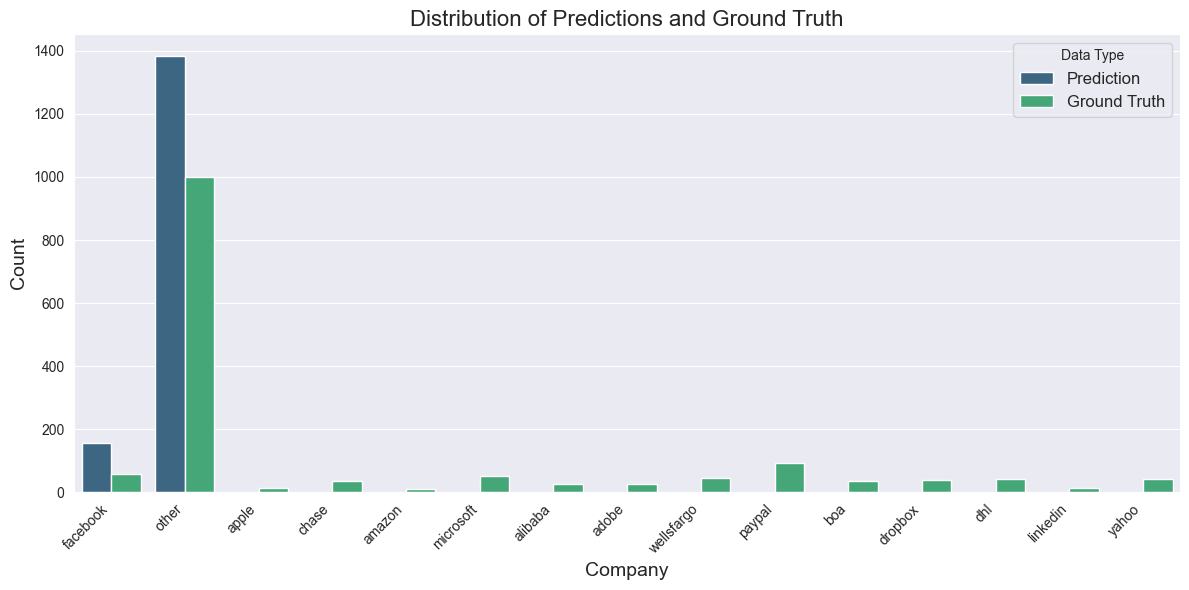

In [27]:
data = pd.DataFrame(
    {
        "Type": ["Prediction"] * len(y_pred) + ["Ground Truth"] * len(y_true),
        "Company": y_pred + y_true,
    }
)

plt.figure(figsize=(12, 6))
sns.countplot(data=data, x="Company", hue="Type", palette="viridis")

plt.title("Distribution of Predictions and Ground Truth", fontsize=16)
plt.xlabel("Company", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Data Type", fontsize=12)
plt.tight_layout()

plt.show()

In [28]:
data[data["Type"] == "Prediction"]["Company"].value_counts()

Company
other       1383
facebook     156
Name: count, dtype: int64

In [29]:
data[data["Type"] == "Ground Truth"]["Company"].value_counts()

Company
other         1000
paypal          93
facebook        57
microsoft       53
wellsfargo      45
yahoo           44
dhl             42
dropbox         40
chase           37
boa             35
adobe           27
alibaba         26
apple           15
linkedin        14
amazon          11
Name: count, dtype: int64